# Detecting plant species based on PlantClef dataset


## Get data

In [ ]:
# ! wget http://otmedia.lirmm.fr/LifeCLEF/PlantCLEF2015/Packages/TrainingPackage/PlantCLEF2015TrainingData.tar.gz

In [ ]:
# ! tar xvzf PlantCLEF2015TrainingData.tar.gz

### Source: https://www.imageclef.org/lifeclef/2016/plant
### Paper: http://ceur-ws.org/Vol-1609/16090428.pdf

### To improve
* consider using some freezing with progressive resizing BUT HOW??
* use DeepAugment - https://blog.insightdatascience.com/automl-for-data-augmentation-e87cf692c366?mc_cid=2736d22830&mc_eid=2fd88701cd
* Use other custom transforms
* Consider using information from family and genus
* use additional dataset - https://www.gbif.org/dataset/search ?
http://leafsnap.com/dataset/
https://www.vicos.si/Downloads/TRUNK12
http://www.robots.ox.ac.uk/~vgg/data/flowers/102/
* what is class id -  the  class  number  ID  that  must  be  used  as  ground-truth.  It  is  anumerical taxonomical number used by Tela Botanica
* Use mean avarage precision to compare to contest data, but how to get that? there was a notebook on forums which was QUITE complicated - https://github.com/sgugger/Deep-Learning/blob/master/mAP/Computing%20the%20mAP%20metric.ipynb
* super convergence WTF https://forums.fast.ai/t/the-1cycle-policy-an-experiment-that-investigate-super-convergence-phenomenon-described-in-leslie-smiths-research/14737
* plot most confused if the problem with confusion persists

### Observations
- most confused seem to differ only in minor details, at 13% error those are really similar plants
- (from miwojc) resnet doesnt do well with that much data and not many epochs, 30-40 minimum, for best performance try to aim for 100ish
- (from Arek) use mixups and own transforms, mixups made it better by 3 %
- what will happen if we use smaller images? like 2 times (around 144)? from 0.74 to what?
- chaning loss function and adjusting dropout has the biggest impact
- with one cycle policy bs does have an influence, so try to use biggest bs memory allows (this can really depend on hardware)
- try experimenting with increasing dropout (ps) and size and see what happens (but how often both should be adjusted???)
- training loss matters

## To look at

* https://github.com/amitkayal/PlantSeedlingsClassification/blob/master/Plant_Seedlings_Classification_fast_ai_categorical_crossentropy.ipynb

## Experiments on 5% on data
- got to accuracy 0f 0.7 with 20 epochs and only 1 stage after adding zoom crop, bs 15, size 299
- got to accuracy of 20 after 6 !!! epochs and 0 drop out and res around 140...
- after adding mixup to above got 0.73 o.o but bs was smaller 14 now and apparetly it makes difference in 1 cycle

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import os

In [3]:
def shutdown():
    os.system('sudo shutdown -h now')

In [4]:
path = Path('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016'); path
# so this is the path that model is saved too FYI

PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016')

In [5]:
path.ls()

[PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/PlantCLEF2015TrainingData.tar.gz'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/RunFilesToolAndResults.zip')]

In [6]:
path_img = path/'train'; path_img

PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train')

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train/62442.jpg'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train/86614.jpg'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train/87071.jpg'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train/101582.jpg'),
 PosixPath('/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train/12556.jpg')]

In [8]:
tfms = get_transforms(do_flip=False, xtra_tfms=zoom_crop(scale=(0.75, 2.2), do_rand=True))
seed = 42
x = 299 // 2
size = x - (x % 7) #when we want to use closest number divisible by 7, because last layer of the net is 7x7
import xml.etree.ElementTree as ET

def get_label_from_xml(file_path):
    parts = file_path.parts
    file_name = parts[-1].replace('jpg', 'xml')
    root = ET.parse(str(path_img/file_name)).getroot()
    return root[7].text

## Check resultion of data

In [9]:
import PIL
size_d = {k: PIL.Image.open(k).size for k in fnames}

row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

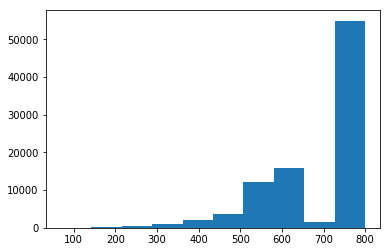

In [10]:
plt.hist(row_sz);

In [11]:
from scipy import stats
m = stats.mode(row_sz)
print(m.mode)

[800]


In [12]:
c = Counter(row_sz.flatten())
print(c.most_common(10))

[(800, 53169), (600, 12787), (533, 4419), (532, 1812), (535, 1137), (531, 705), (450, 655), (530, 513), (449, 292), (536, 208)]


## Create image data bunch

In [9]:
np.random.seed(42)
seed = 42
pct = 0.05
bs = 64
src = (ImageList.from_folder(path_img)
        .use_partial_data(pct, seed) #comment out for learning
        .split_by_rand_pct()
        .label_from_func(get_label_from_xml)
        .add_test_folder())
data = (src
        .transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

(1000, 73407, 18351)

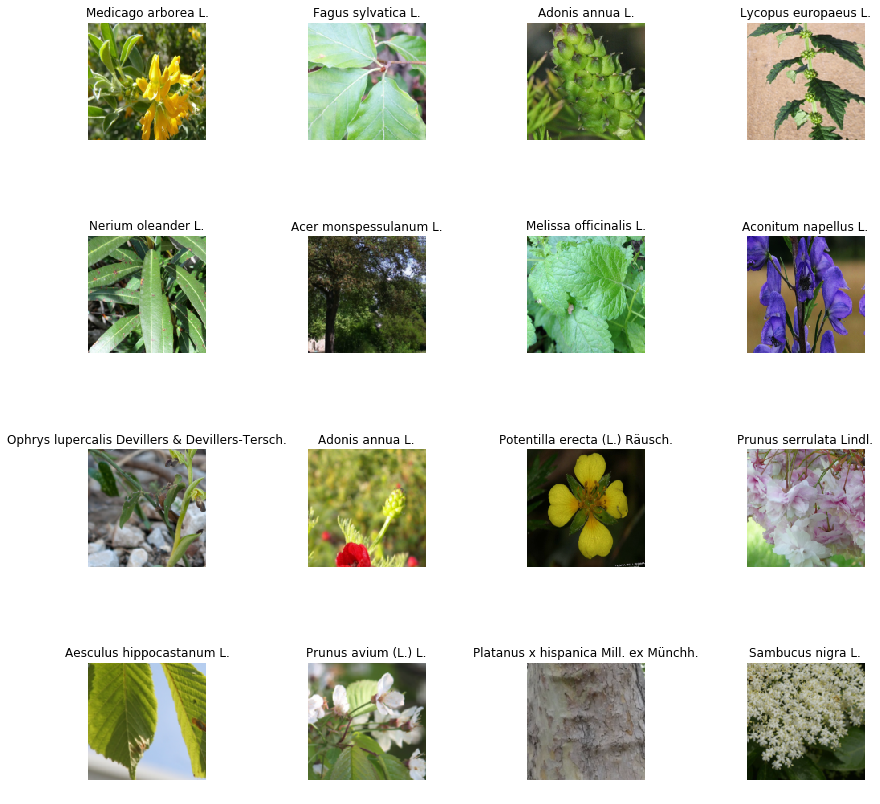

In [10]:
data.show_batch(rows=4, figsize=(12, 12))
data.c, len(data.train_ds), len(data.valid_ds)

# Experiments 
zoom crop with random set to false, so comparisions are more accurate

 ## Testing mixups

In [17]:
arch = models.resnet50

In [18]:
learn = cnn_learner(data, arch, metrics=error_rate)#.mixup()

In [19]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,7.247932,6.673122,0.972603,00:30
1,6.669492,6.056622,0.924658,00:28
2,6.004565,5.630483,0.898402,00:28
3,5.266775,5.283186,0.861872,00:28
4,4.629333,5.125268,0.850457,00:28
5,4.011709,4.981282,0.831050,00:28
6,3.464279,4.939465,0.813927,00:28
7,2.971256,4.912940,0.791096,00:28
8,2.649195,4.885494,0.795662,00:27
9,2.466856,4.886590,0.794521,00:28


In [20]:
learn1 = cnn_learner(data, arch, metrics=error_rate).mixup()
learn1.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,7.304965,6.749847,0.988584,00:27
1,6.905079,6.273811,0.936073,00:28
2,6.413036,5.804101,0.924658,00:28
3,5.888395,5.544829,0.905251,00:28
4,5.438171,5.347179,0.868721,00:28
5,5.025706,5.217907,0.835616,00:28
6,4.691879,5.148357,0.847032,00:28
7,4.412642,5.103833,0.839041,00:27
8,4.216475,5.072292,0.832192,00:28
9,4.045672,5.067655,0.834475,00:28


#### There is 2% difference BUT mixup has way lower train loss, meaning we can train for longer, so desptite worse error I'll use it

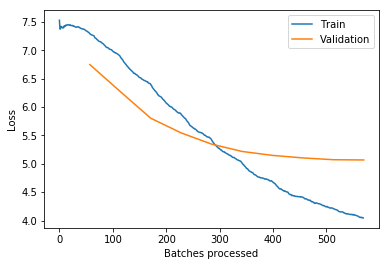

In [21]:
learn1.recorder.plot_losses()

## Testing resnet 101 with mixups

In [22]:
learn2 = cnn_learner(data, models.resnet101, metrics=error_rate).mixup()
learn2.fit_one_cycle(10) # I dont really understand why resnet101 performs worse than resnet50

epoch,train_loss,valid_loss,error_rate,time
0,7.380113,7.183139,0.986301,00:35
1,6.885063,6.440876,0.949772,00:35
2,6.393036,6.029113,0.922374,00:35
3,5.893717,5.640108,0.897260,00:36
4,5.452078,5.407155,0.858447,00:36
5,5.016545,5.310385,0.856164,00:35
6,4.649774,5.248611,0.843607,00:35
7,4.334136,5.210130,0.842466,00:35
8,4.143083,5.195582,0.837900,00:36
9,4.036198,5.145678,0.835616,00:36


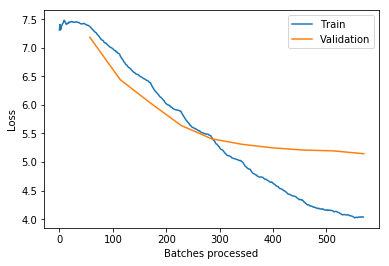

In [23]:
learn2.recorder.plot_losses() # validation odd is really odd, it takes giant jump and then goes hand in hand with train loss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


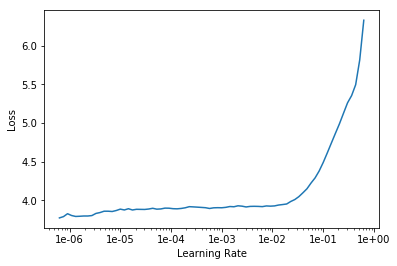

In [24]:
learn2.lr_find()
learn2.recorder.plot()

## Experimenting with zoom crop and transforms

### Default zoom crop

In [25]:
tfms = get_transforms(do_flip=False, xtra_tfms=zoom_crop(scale=(0.75, 2), do_rand=False))

In [26]:
np.random.seed(42)
seed = 42
pct = 0.05
#size = 244
data = (src
        .transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

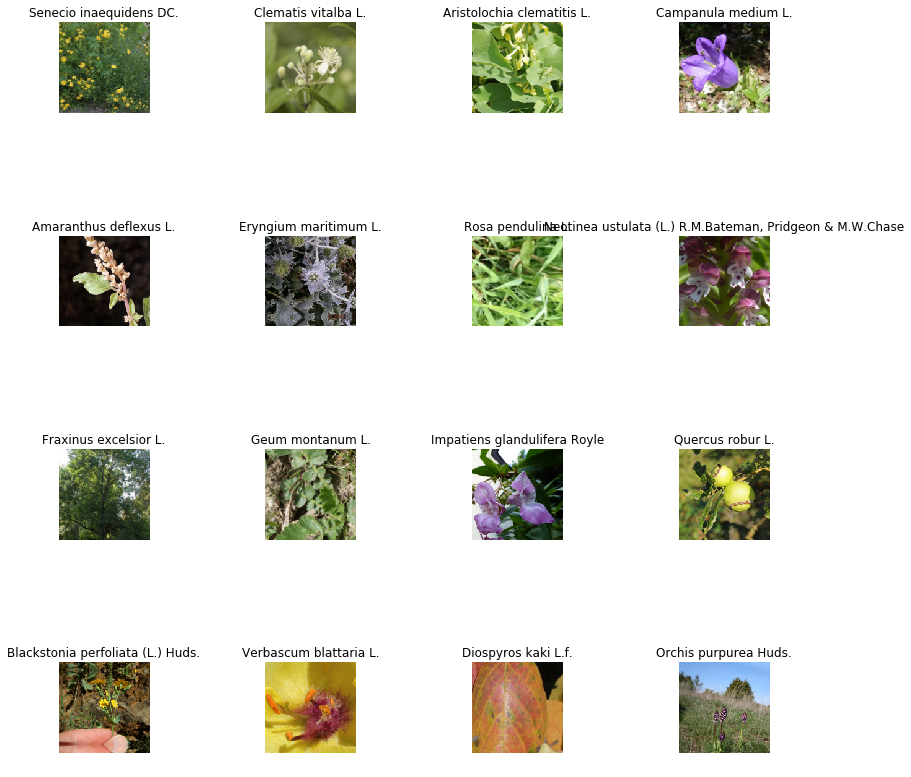

In [27]:
data.show_batch(rows=4, figsize=(12, 12))

In [28]:
learn = cnn_learner(data, arch, metrics=error_rate)

In [29]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,7.062100,6.325887,0.948630,00:29
1,6.214654,5.738965,0.904110,00:29
2,5.321659,5.459002,0.889269,00:29
3,4.563063,5.400822,0.880137,00:29


### Higher end scale form zoom crop

In [30]:
tfms = get_transforms(do_flip=False, xtra_tfms=zoom_crop(scale=(0.75, 2.2), do_rand=False))

In [31]:
np.random.seed(42)
seed = 42
pct = 0.05
#size = 244
data = (src
        .transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

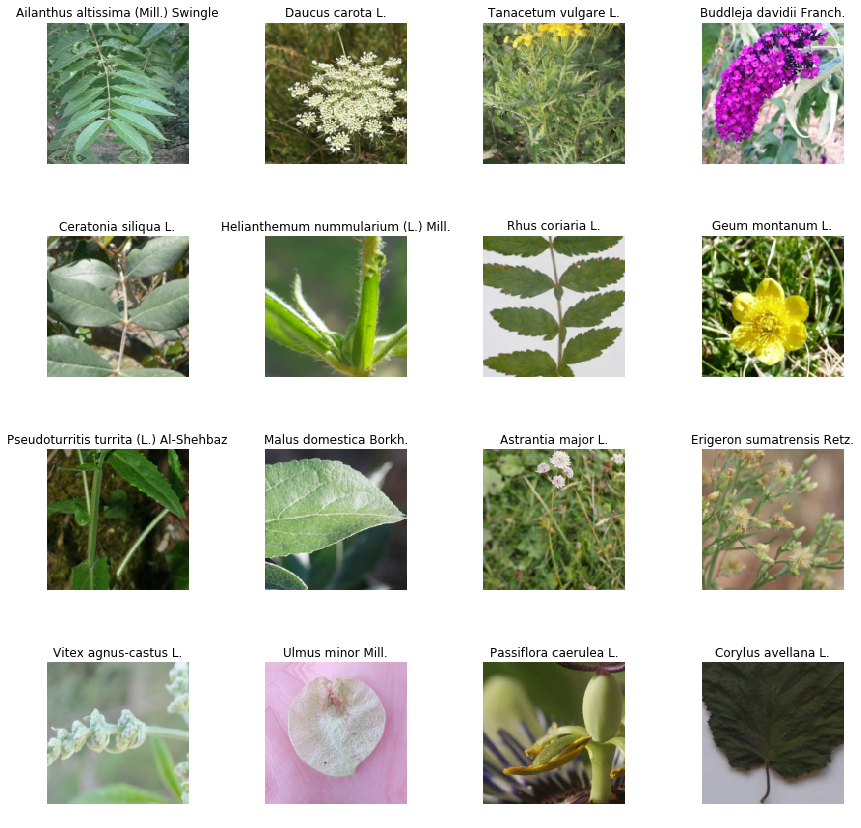

In [32]:
data.show_batch(rows=4, figsize=(12, 12))

In [33]:
learn = cnn_learner(data, arch, metrics=error_rate)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,7.188946,6.505197,0.960046,00:28
1,6.386715,5.832128,0.910959,00:28
2,5.554179,5.480594,0.883562,00:29
3,4.724334,5.281781,0.858447,00:28
4,4.005245,5.179817,0.853881,00:28
5,3.546304,5.157724,0.852740,00:28


Error rate is worse, but we can train for longer because the training loss is going slower, so 2.2 it is (the exact number was found after few tries).

## Experimenting with loss function

### Default cross entropy

In [34]:
learn = cnn_learner(data, arch, metrics=error_rate)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,7.241939,6.508046,0.966895,00:28
1,6.440411,5.819094,0.901827,00:28
2,5.576336,5.471641,0.864155,00:28
3,4.715265,5.282527,0.851598,00:28
4,3.984163,5.200079,0.832192,00:28
5,3.510754,5.176421,0.827626,00:28


### Multi label margin loss

In [35]:
learn = cnn_learner(data, arch, metrics=error_rate)
learn.loss_function = torch.nn.MultiLabelMarginLoss()
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,7.164016,6.480835,0.964612,00:28
1,6.395668,5.851265,0.915525,00:28
2,5.550060,5.466198,0.881279,00:29
3,4.740597,5.277524,0.857306,00:28
4,3.992377,5.169425,0.835616,00:28
5,3.498312,5.154417,0.831050,00:29


## Dropout rate

### Default - 0.5

In [36]:
learn = cnn_learner(data, arch, metrics=error_rate)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,7.219670,6.512704,0.955479,00:27
1,6.433104,5.841949,0.917808,00:28
2,5.582538,5.504622,0.896119,00:29
3,4.737668,5.317166,0.852740,00:28
4,3.999974,5.226264,0.844749,00:28
5,3.522211,5.206007,0.843607,00:28


### Significantly lower than default - 0.3

In [37]:
learn = cnn_learner(data, arch, metrics=error_rate, ps=0.3)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,6.950186,6.380288,0.947489,00:28
1,6.099309,5.715650,0.900685,00:27
2,5.083649,5.344211,0.875571,00:28
3,4.055055,5.196128,0.837900,00:28
4,3.116427,5.121495,0.820776,00:28
5,2.539691,5.116919,0.816210,00:28


### No dropout

In [38]:
learn = cnn_learner(data, arch, metrics=error_rate, ps=0)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,6.750942,6.220053,0.929224,00:28
1,5.751290,5.548768,0.877854,00:28
2,4.500538,5.288504,0.842466,00:29
3,3.228140,5.178809,0.816210,00:28
4,2.145066,5.167942,0.813927,00:28
5,1.547464,5.163928,0.807078,00:27


### Even lower - 0.1 holy cow :o

In [39]:
learn = cnn_learner(data, arch, metrics=error_rate, ps=0.1)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,6.837175,6.301785,0.948630,00:28
1,5.891028,5.573576,0.898402,00:28
2,4.678526,5.293033,0.842466,00:28
3,3.457879,5.210948,0.825342,00:27
4,2.435079,5.165629,0.819635,00:28
5,1.808557,5.152159,0.812785,00:28


## Experiment with to_fp16

### Default

In [40]:
learn = cnn_learner(data, arch, metrics=error_rate)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,7.238750,6.551253,0.968037,00:28
1,6.451076,5.874133,0.920091,00:28
2,5.567133,5.511028,0.876712,00:28
3,4.746727,5.310117,0.867580,00:28
4,4.010535,5.217279,0.845890,00:28
5,3.554123,5.197226,0.849315,00:28


### Floating point with 16 bit precision

In [41]:
learn = to_fp16(cnn_learner(data, arch, metrics=error_rate))
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,7.235836,6.436023,0.950913,00:29
1,6.450179,5.818324,0.909817,00:28
2,5.556570,5.495900,0.881279,00:27
3,4.717058,5.304005,0.847032,00:27
4,3.967557,5.190482,0.824201,00:27
5,3.494268,5.175185,0.821918,00:27


fp_16 made really big difference when running on full dataset as far as I remember it made training 2x faster

## Size

In [ ]:
x = 299 // 2
bs = 64
size = x - (x % 7) 
data = (ImageList.from_folder(path_img)
        .use_partial_data(pct, seed) #comment out for learning
        .split_by_rand_pct()
        .label_from_func(get_label_from_xml)
        .add_test_folder()
        .transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = cnn_learner(data, arch, metrics=error_rate)
learn.fit_one_cycle(6)

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Gagea granatelli (Parl.) Parl., Achillea ptarmica L., Aristolochia pistolochia L., Sedum rupestre L., Asphodelus albus Mill....
  if getattr(ds, 'warn', False): warn(ds.warn)


epoch,train_loss,valid_loss,error_rate,time
0,7.145565,6.477526,0.960046,00:28
1,6.407955,5.807197,0.909817,00:28
2,5.563651,5.474678,0.881279,00:28
3,4.712960,5.300626,0.850457,00:28
4,3.993684,5.187230,0.826484,00:28
5,3.546677,5.172344,0.827626,00:28


In [ ]:
x = 299 // 3
bs = 256
size = x - (x % 7) 
data = (src
        .transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = cnn_learner(data, arch, metrics=error_rate)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,7.417864,6.731113,0.981735,00:27
1,6.967369,6.326552,0.939498,00:24
2,6.456082,6.010696,0.925799,00:25
3,5.991827,5.822512,0.907534,00:25
4,5.585941,5.740234,0.891553,00:25
5,5.291730,5.729493,0.891553,00:24


In [ ]:
x = 299 // 4
bs = 512
size = x - (x % 7) 
data = (src
        .transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = cnn_learner(data, arch, metrics=error_rate)
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,7.433488,6.806777,0.989726,00:34
1,7.145157,6.589033,0.965753,00:26
2,6.806379,6.360131,0.940639,00:27
3,6.493565,6.203069,0.933790,00:27
4,6.223700,6.129735,0.926941,00:27
5,6.027521,6.116223,0.925799,00:26


## Actual Learning on resnet50

In [11]:
x = 299 // 2
size = x - (x % 7)

np.random.seed(42)
seed = 42
pct = 0.05
bs = 64
src = (ImageList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_label_from_xml)
        .add_test_folder())
data = (src
        .transform(tfms, size=size)
        .databunch(bs=bs*2)
        .normalize(imagenet_stats))

In [12]:
arch = models.resnet50
learn = to_fp16(cnn_learner(data, arch, metrics=error_rate, ps=0.1)).mixup()
learn.loss_function = torch.nn.MultiLabelMarginLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


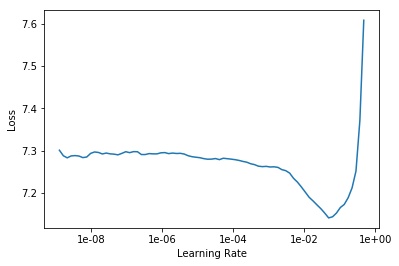

In [13]:
learn.lr_find(start_lr=1e-10)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(30, max_lr=slice(None, 5e-3))
# prev ended on 0.355348, used higher lr because of how training loss plot looked

epoch,train_loss,valid_loss,error_rate,time
0,5.756648,5.030325,0.835758,13:38
1,4.976317,4.005156,0.739033,07:58
2,4.599493,3.465159,0.668247,07:57
3,4.322984,3.175402,0.632881,07:57
4,4.180560,2.961401,0.599804,07:56
5,4.086175,2.791845,0.567163,07:57
6,3.917269,2.656882,0.546837,07:57
7,3.780323,2.528624,0.520898,08:00
8,3.711859,2.420946,0.499046,07:58
9,3.571115,2.319100,0.482535,08:00


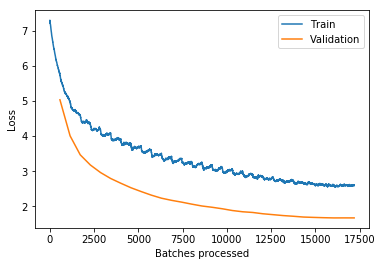

In [15]:
learn.recorder.plot_losses()

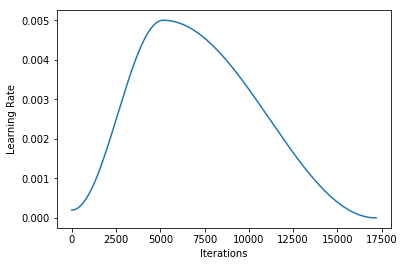

In [16]:
learn.recorder.plot_lr()

In [17]:
learn.save('stage-1')

### More learning with different lr and higher drop out (ps)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


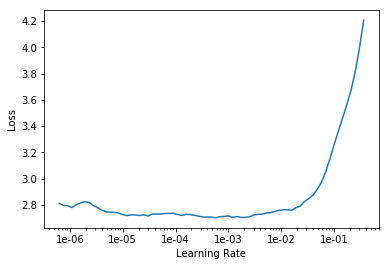

In [18]:
learn = to_fp16(cnn_learner(data, arch, metrics=error_rate, ps=0.2)).mixup()
learn.loss_function = torch.nn.MultiLabelMarginLoss()
learn.load('stage-1')
learn.lr_find(start_lr=1e-7)
learn.recorder.plot()

In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(20, max_lr=slice(1e-5,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.766042,1.672885,0.348864,08:28
1,2.860052,1.718098,0.361506,08:35
2,2.934884,1.796840,0.377255,08:30
3,3.050859,1.910167,0.398234,08:34
4,3.132304,1.924600,0.405264,08:34
5,3.104926,1.874097,0.396709,08:23
6,3.016709,1.768556,0.374911,08:25
7,2.946901,1.721944,0.365212,08:20
8,2.898700,1.666283,0.357147,08:19
9,2.812458,1.588723,0.340908,08:20


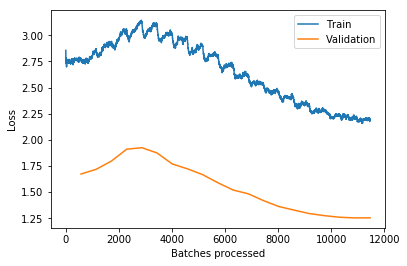

In [21]:
learn.recorder.plot_losses()

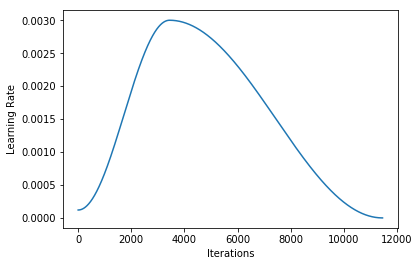

In [22]:
learn.recorder.plot_lr()

In [23]:
learn.save('stage-2')

In [24]:
learn = to_fp16(cnn_learner(data, arch, metrics=error_rate, ps=0.3)).mixup()
learn.loss_function = torch.nn.MultiLabelMarginLoss()
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (73407 items)
x: ImageList
Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147)
y: CategoryList
Ailanthus altissima (Mill.) Swingle,Ononis minutissima L.,Lavandula stoechas L.,Limonium vulgare Mill.,Dipcadi serotinum (L.) Medik.
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train;

Valid: LabelList (18351 items)
x: ImageList
Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147)
y: CategoryList
Carlina corymbosa L.,Phillyrea angustifolia L.,Silene nutans L.,Cercis siliquastrum L.,Melissa officinalis L.
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


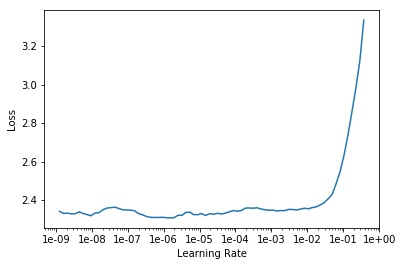

In [25]:
learn.lr_find(start_lr=1e-10)
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4)) #ok, so this isn't really doing anything, probably needs experimenting with lr

epoch,train_loss,valid_loss,error_rate,time
0,2.342244,1.251930,0.263419,07:59
1,2.337201,1.249369,0.263473,08:00
2,2.344224,1.248761,0.264127,08:03
3,2.331036,1.248330,0.263310,07:59
4,2.349388,1.246010,0.264236,08:03
5,2.321588,1.245791,0.263528,08:02
6,2.318403,1.243960,0.263855,08:04
7,2.292867,1.242665,0.263582,08:03
8,2.327986,1.244760,0.264563,08:05
9,2.298418,1.245836,0.263146,08:04


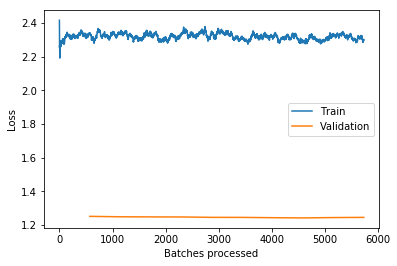

In [27]:
learn.recorder.plot_losses()

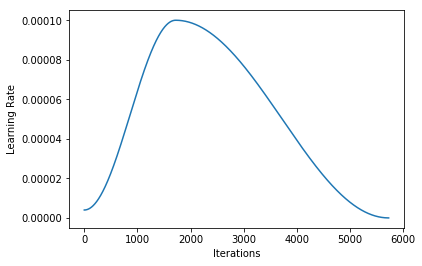

In [28]:
learn.recorder.plot_lr()

In [29]:
learn.save('stage-3')

In [30]:
learn = to_fp16(cnn_learner(data, arch, metrics=error_rate, ps=0.4)).mixup()
learn.loss_function = torch.nn.MultiLabelMarginLoss()
learn.load('stage-3')

Learner(data=ImageDataBunch;

Train: LabelList (73407 items)
x: ImageList
Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147)
y: CategoryList
Ailanthus altissima (Mill.) Swingle,Ononis minutissima L.,Lavandula stoechas L.,Limonium vulgare Mill.,Dipcadi serotinum (L.) Medik.
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train;

Valid: LabelList (18351 items)
x: ImageList
Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147),Image (3, 147, 147)
y: CategoryList
Carlina corymbosa L.,Phillyrea angustifolia L.,Silene nutans L.,Cercis siliquastrum L.,Melissa officinalis L.
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


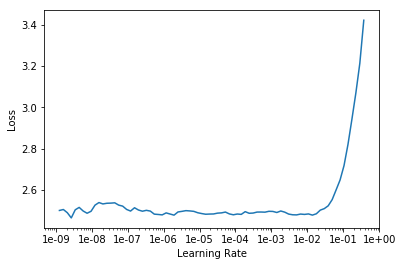

In [31]:
learn.lr_find(start_lr=1e-10)
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,3e-4)) #this isn't really doing anything, probably needs experimenting with lr

epoch,train_loss,valid_loss,error_rate,time
0,2.501627,1.244717,0.262983,07:58
1,2.487149,1.248057,0.264509,07:59
2,2.488607,1.247655,0.263746,07:57
3,2.478052,1.250124,0.262166,07:56
4,2.458459,1.245287,0.263473,07:54
5,2.447118,1.245991,0.262002,07:56
6,2.478961,1.242025,0.261893,08:00
7,2.455663,1.238540,0.262438,07:59
8,2.431782,1.243935,0.263037,08:02
9,2.419551,1.242581,0.263255,07:59


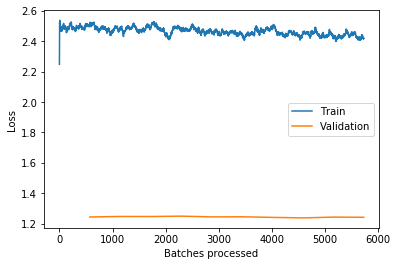

In [33]:
learn.recorder.plot_losses()

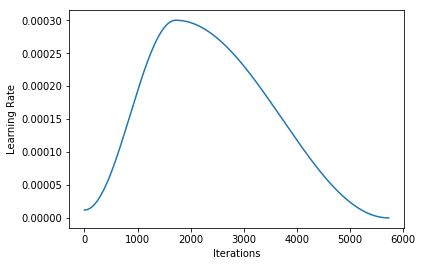

In [34]:
learn.recorder.plot_lr()

In [35]:
learn.save('stage-4')

## Use higher resolution -299

In [36]:
size = 299
data = (ImageList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_label_from_xml)
        .add_test_folder()
        .transform(tfms, size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [37]:
learn = to_fp16(cnn_learner(data, arch, metrics=error_rate, ps=0.4)).mixup()
learn.loss_function = torch.nn.MultiLabelMarginLoss()
learn.load('stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (73407 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Ailanthus altissima (Mill.) Swingle,Lavandula stoechas L.,Limonium vulgare Mill.,Bistorta officinalis Delarbre,Erigeron sumatrensis Retz.
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train;

Valid: LabelList (18351 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Prunus avium (L.) L.,Gentiana verna L.,Celtis australis L.,Lythrum salicaria L.,Prospero autumnale (L.) Speta
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3),

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


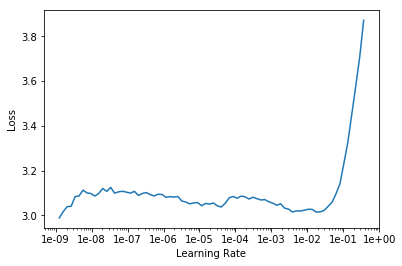

In [38]:
learn.lr_find(start_lr=1e-10)
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(20, max_lr=slice(1e-7,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.978708,0.483573,0.092366,18:22
1,2.859627,0.488931,0.091657,18:19
2,2.774279,0.517122,0.101193,18:18
3,2.852495,0.565796,0.115689,18:19
4,2.859507,0.638578,0.133780,18:24
5,2.882873,0.693391,0.148984,18:26
6,2.829777,0.714578,0.159119,18:24
7,2.832175,0.733087,0.159119,18:22
8,2.787827,0.738768,0.161517,18:22
9,2.739944,0.734583,0.160318,18:22


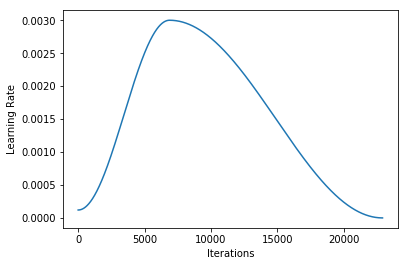

In [40]:
learn.recorder.plot_lr()

In [41]:
learn.save('stage-1-299')

In [45]:
learn.load('stage-1-299')

Learner(data=ImageDataBunch;

Train: LabelList (73407 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Ailanthus altissima (Mill.) Swingle,Lavandula stoechas L.,Limonium vulgare Mill.,Bistorta officinalis Delarbre,Erigeron sumatrensis Retz.
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train;

Valid: LabelList (18351 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Prunus avium (L.) L.,Gentiana verna L.,Celtis australis L.,Lythrum salicaria L.,Prospero autumnale (L.) Speta
Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /home/jupyter/tutorials/fastai/course-v3/nbs/dl1/PlantCLEF/2016/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3),

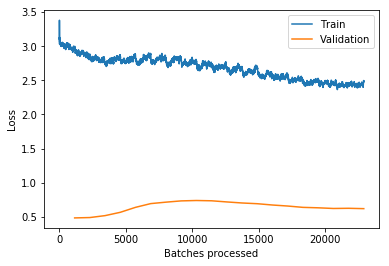

In [42]:
learn.recorder.plot_losses() 
#from what it loooks like, higher starting lr could be used, but for now error 13% is enough

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


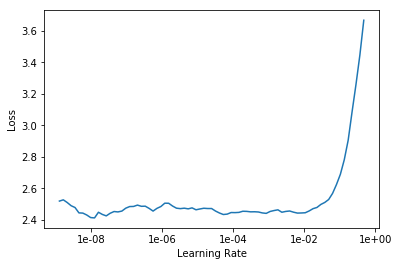

In [43]:
learn.lr_find(start_lr=1e-10)
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,3e-4)) 
# needs adjustment for lr, abandoned further learning because got good enough results

epoch,train_loss,valid_loss,error_rate,time
0,2.493481,0.619653,0.132363,18:21
1,2.428978,0.622094,0.132963,18:21
2,2.394439,0.619057,0.132200,18:19
3,2.434673,0.614178,0.133181,18:20
4,2.430025,0.612109,0.133998,18:23
5,2.457935,0.602704,0.132036,18:23


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "

KeyboardInterrupt: 

In [ ]:
learn.recorder.plot()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-2-299')

## Higher res - 500ish

In [ ]:
x = 299 * 2
size = x - (x % 7)
data = (ImageList.from_folder(path_img)
       # .use_partial_data(pct, seed) #comment out for learning
        .split_by_rand_pct()
        .label_from_func(get_label_from_xml)
        .add_test_folder()
        .transform(tfms, size=size)
        .databunch(bs=bs//4)
        .normalize(imagenet_stats))

In [ ]:
size

In [ ]:
learn = to_fp16(cnn_learner(data, arch, metrics=error_rate)).mixup()
learn.loss_function = torch.nn.MultiLabelMarginLoss()
learn.load('stage-2-299')

In [ ]:
learn.lr_find(start_lr=1e-10)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,3e-3))

In [ ]:
learn.save('stage-1-500')

In [ ]:
learn.recorder.plot_losses()

## Results interpretation

In [46]:
interp = ClassificationInterpretation.from_learner(learn)

In [47]:
interp.most_confused(min_val=2) 

[('Crataegus azarolus L.', 'Crataegus monogyna Jacq.', 8),
 ('Fraxinus angustifolia Vahl', 'Fraxinus excelsior L.', 7),
 ('Centaurea decipiens Thuill.', 'Centaurea jacea L.', 6),
 ('Vinca major L.', 'Vinca minor L.', 5),
 ('Aesculus hippocastanum L.', 'Crataegus monogyna Jacq.', 4),
 ('Asphodelus ramosus L.', 'Asphodelus cerasiferus J.Gay', 4),
 ('Betula pubescens Ehrh.', 'Betula pendula Roth', 4),
 ('Campanula persicifolia L.', 'Campanula scheuchzeri Vill.', 4),
 ('Cornus mas L.', 'Cornus sanguinea L.', 4),
 ('Dactylorhiza fuchsii (Druce) Soó', 'Dactylorhiza maculata (L.) Soó', 4),
 ('Hypochaeris radicata L.', 'Taraxacum officinale F.H.Wigg.', 4),
 ('Jacobaea erucifolia (L.) P.Gaertn., B.Mey. & Scherb.',
  'Jacobaea vulgaris Gaertn.',
  4),
 ('Juniperus phoenicea L.', 'Arbutus unedo L.', 4),
 ('Limonium narbonense Mill.', 'Limonium vulgare Mill.', 4),
 ('Pinus mugo Turra', 'Pinus cembra L.', 4),
 ('Quercus pubescens Willd.', 'Quercus robur L.', 4),
 ('Tilia cordata Mill.', 'Tilia plat

In [50]:
interp.most_confused(min_val=3), len(interp.most_confused(min_val=3))

([('Crataegus azarolus L.', 'Crataegus monogyna Jacq.', 8),
  ('Fraxinus angustifolia Vahl', 'Fraxinus excelsior L.', 7),
  ('Centaurea decipiens Thuill.', 'Centaurea jacea L.', 6),
  ('Vinca major L.', 'Vinca minor L.', 5),
  ('Aesculus hippocastanum L.', 'Crataegus monogyna Jacq.', 4),
  ('Asphodelus ramosus L.', 'Asphodelus cerasiferus J.Gay', 4),
  ('Betula pubescens Ehrh.', 'Betula pendula Roth', 4),
  ('Campanula persicifolia L.', 'Campanula scheuchzeri Vill.', 4),
  ('Cornus mas L.', 'Cornus sanguinea L.', 4),
  ('Dactylorhiza fuchsii (Druce) Soó', 'Dactylorhiza maculata (L.) Soó', 4),
  ('Hypochaeris radicata L.', 'Taraxacum officinale F.H.Wigg.', 4),
  ('Jacobaea erucifolia (L.) P.Gaertn., B.Mey. & Scherb.',
   'Jacobaea vulgaris Gaertn.',
   4),
  ('Juniperus phoenicea L.', 'Arbutus unedo L.', 4),
  ('Limonium narbonense Mill.', 'Limonium vulgare Mill.', 4),
  ('Pinus mugo Turra', 'Pinus cembra L.', 4),
  ('Quercus pubescens Willd.', 'Quercus robur L.', 4),
  ('Tilia cordata 

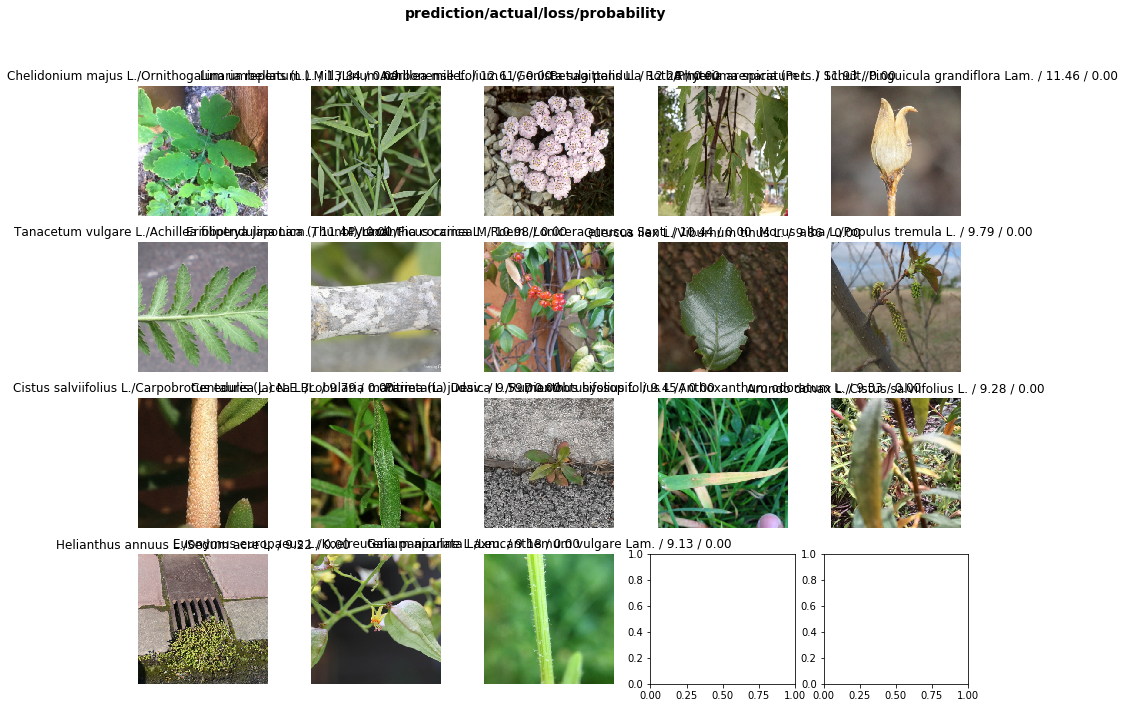

In [53]:
interp.plot_top_losses(18, figsize=(15,11), heatmap=False)

In [ ]:
shutdown()

## The end, my only friend the end